In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['ActualFlightTime'] = np.log(df['ActualFlightTime'] + 1)
    df['ActualTotalFuel'] = np.log(df['ActualTotalFuel'] + 1)
    df['FlownPassengers'] = np.log(df['FlownPassengers'] + 1)
    df['BagsCount'] = np.log(df['BagsCount'] + 1)
    df['FlightBagsWeight'] = np.log(df['FlightBagsWeight'] + 1)

    df['flight_time_fuel_ratio'] = df['ActualFlightTime'] / df['ActualTotalFuel']
    df['bags_weight_ratio'] = df['FlightBagsWeight'] / df['BagsCount']
    df['bags_passengers_ratio'] = df['BagsCount'] / df['FlownPassengers']

    df['flight_time_fuel_ratio'] = np.where(np.isfinite(df['flight_time_fuel_ratio']), df['flight_time_fuel_ratio'], 0)
    df['bags_weight_ratio'] = np.where(np.isfinite(df['bags_weight_ratio']), df['bags_weight_ratio'], 0)
    df['bags_passengers_ratio'] = np.where(np.isfinite(df['bags_passengers_ratio']), df['bags_passengers_ratio'], 0)

    return df

In [3]:
train_df = preprocess_data('input_refactor/training_refactor.csv')
x_train, y_train = train_df.drop('ActualTOW', axis=1), train_df['ActualTOW']

array([[<Axes: title={'center': 'DepartureDate'}>,
        <Axes: title={'center': 'DepartureYear'}>,
        <Axes: title={'center': 'DepartureMonth'}>,
        <Axes: title={'center': 'DepartureDay'}>],
       [<Axes: title={'center': 'FlightNumber'}>,
        <Axes: title={'center': 'DepartureAirport'}>,
        <Axes: title={'center': 'ArrivalAirport'}>,
        <Axes: title={'center': 'Route'}>],
       [<Axes: title={'center': 'ActualFlightTime'}>,
        <Axes: title={'center': 'ActualTotalFuel'}>,
        <Axes: title={'center': 'ActualTOW'}>,
        <Axes: title={'center': 'FlownPassengers'}>],
       [<Axes: title={'center': 'BagsCount'}>,
        <Axes: title={'center': 'FlightBagsWeight'}>,
        <Axes: title={'center': 'flight_time_fuel_ratio'}>,
        <Axes: title={'center': 'bags_weight_ratio'}>],
       [<Axes: title={'center': 'bags_passengers_ratio'}>, <Axes: >,
        <Axes: >, <Axes: >]], dtype=object)

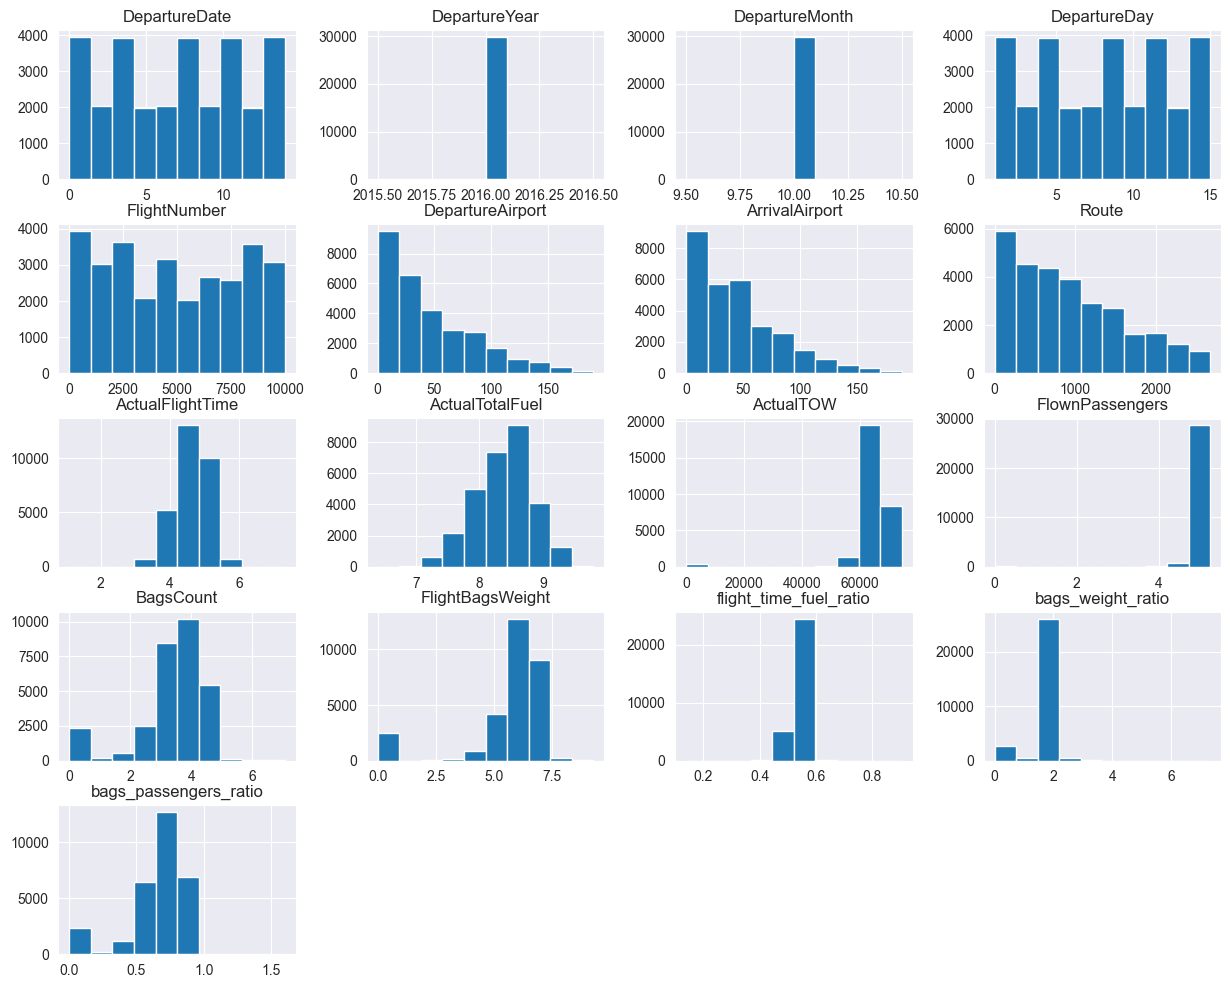

In [4]:
train_df.hist(figsize=(15, 12))

<Axes: >

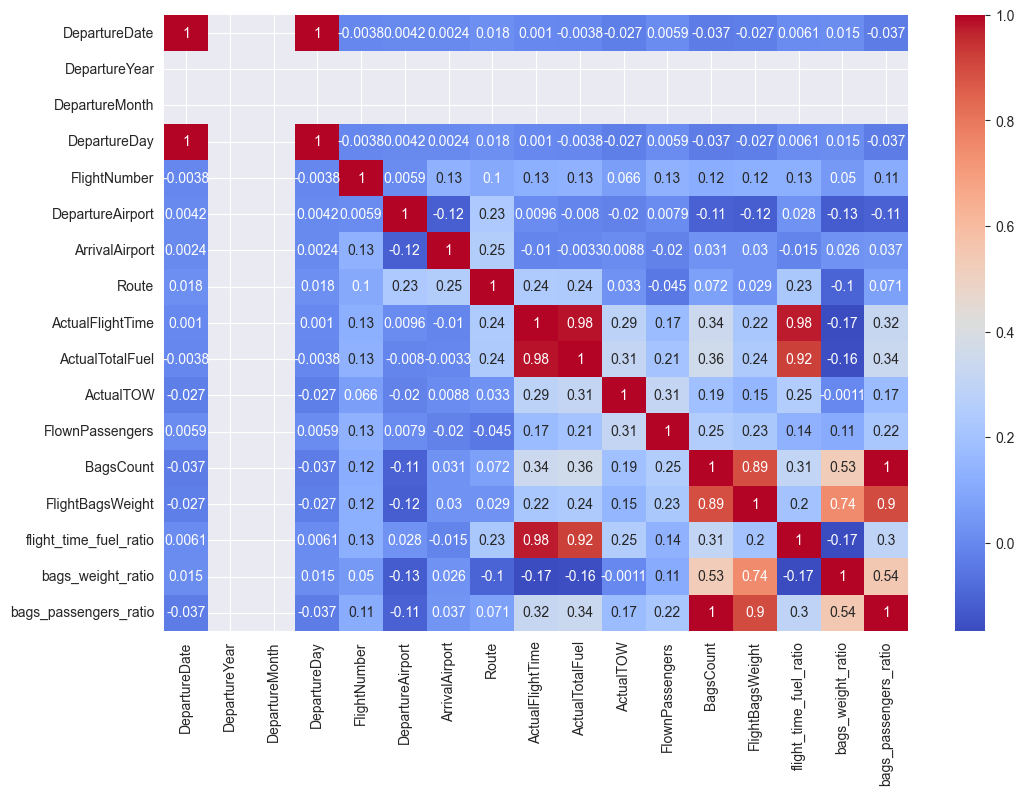

In [6]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm')

In [7]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

In [8]:
forest = RandomForestRegressor()
# forest.fit(x_train_scaled, y_train)
param_grid = {}
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(x_train_scaled, y_train)

# This take too much time to compile
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 4, 8],
#     'min_samples_split': [2, 4]
# }
# 
# grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5,
#                            scoring='neg_mean_squared_error',
#                            return_train_score=True)
# 
# grid_search.fit(x_train_scaled, y_train)

#Second option for time saving - not good enough compared to a default settings
# param_dist = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 4, 8],
#     'min_samples_split': [2, 4]
# }
# 
# random_search = RandomizedSearchCV(estimator=forest, param_distributions=param_dist, cv=5,
#                                    scoring='neg_mean_squared_error', n_iter=10,
#                                    return_train_score=True)
# 
# random_search.fit(x_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), param_grid={},
             return_train_score=True, scoring='neg_mean_squared_error')

In [9]:
best_model = grid_search.best_estimator_
# best_model = random_search.best_estimator_
# best_model = forest

In [10]:
best_model.score(x_train_scaled, y_train)

0.8824269435975208

In [12]:
rmse = np.sqrt(mean_squared_error(y_train, best_model.predict(x_train_scaled)))
print('RMSE:', rmse)

RMSE: 2903.108957560274


In [13]:
val_df = preprocess_data('input_refactor/validation_refactor.csv')

In [14]:
x_val_scaled = scaler.transform(val_df)

In [15]:
predictions = best_model.predict(x_val_scaled)

In [16]:
output_directory = 'output'
os.makedirs(output_directory, exist_ok=True)

output_path = os.path.join(output_directory, 'output.csv')
val_df['PredictedActualTOW'] = predictions
val_df.to_csv(output_path, index=False)

print('Data saved to', output_path)

Data saved to output\output.csv
